In [1]:
import glob
import os
from typing import List, Sequence, Dict
from collections import namedtuple

import datetime

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

import boa.acquisition.util as util
from boa.optimization.data import FileHandler, Data

from pygmo import hypervolume

save_folder = "../plots/notebook_plots/bayesopt_analysis/"

DataTuple = namedtuple('DataTuple', field_names=['df', 'input_labels', 'output_labels'])

In [2]:
smaug_experiment_dir = "/scratch/gf332/BayesOpt/smaug"
aladdin_experiment_dir = "/scratch/gf332/BayesOpt/gem5-aladdin"

In [21]:
data_subdirs = {
#     "GPAR, 20k points": "test_19/evaluation_49",
#     "GPAR, 200k points": "test_20/evaluation_39",
    "FF-GP, 20k points": "test_22/evaluation_49",
    "Random, 200k points": "test_21/evaluation_49",
    "GPAR Full": "test_full_gpar/evaluation_49",
#     "GPAR grid refine": "test_gpar_grid_refined/evaluation_49",
    "BNN": "test_bnn/evaluation_49",
    "BNN out std": "test_bnn_out_std/evaluation_49",
}

num_targets = 3

In [22]:
data_arrays = {k: np.load(os.path.join(smaug_experiment_dir, v, "ys.npy"))[:, -num_targets:] 
               for k, v in data_subdirs.items()}
ys = np.concatenate([v for _, v in data_arrays.items()], axis=0)

ys_max = np.max(ys, axis=0)
ys_min = np.min(ys, axis=0)

normed_reference = np.array([1, 1, 1])

In [23]:
hypervolumes = {}

for label, data in data_arrays.items():

    norm_data = (data - ys_min) / (ys_max - ys_min)

    hvs = []

    for i in range(1, norm_data.shape[0]):
        hv = hypervolume(points=norm_data[:i, :]).compute(normed_reference)
        hvs.append(hv)
        
    hypervolumes[label] = hvs

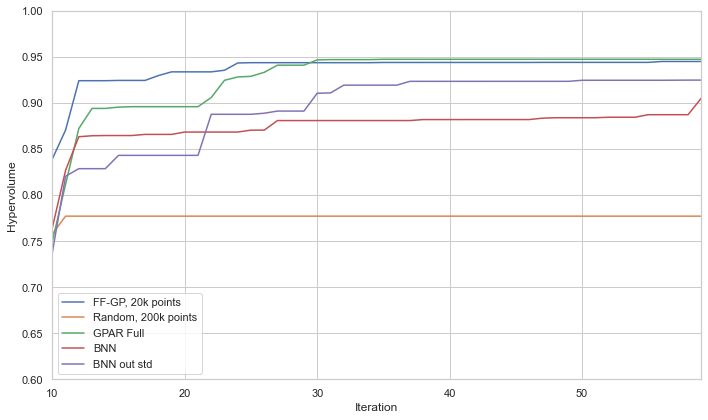

In [24]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))

for label, hypervols in hypervolumes.items():

    ax.plot(range(1, len(hypervols) + 1), hypervols, label=label)

ax.set_ylabel("Hypervolume")
ax.set_xlabel("Iteration")

ax.set_xlim([10, 59])
ax.set_ylim([0.6, 1.])

ax.legend()
fig.tight_layout()

fig.savefig("./boa.png")

plt.show()

In [12]:
# TODO control grid refinement by defining some invariant, like 
# num_pa